In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving healith_patients_week3.csv to healith_patients_week3.csv
Saving financia_transactions_week2.csv to financia_transactions_week2.csv
User uploaded file "healith_patients_week3.csv" with length 917105 bytes
User uploaded file "financia_transactions_week2.csv" with length 2428521 bytes


In [2]:
import pandas as pd
df = pd.read_csv("financia_transactions_week2.csv", parse_dates=["timestamp"])
df.shape, df.is_fraud.mean()


((25000, 11), np.float64(0.02444))

In [3]:
from sklearn.model_selection import train_test_split
features = ["amount","hour","dayofweek","is_international","device_trust",
            "account_age_days","merchant_risk","past_24h_txn_count","velocity_amount_1h"]
X, y = df[features], df["is_fraud"]

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix, classification_report

lr = LogisticRegression(max_iter=200, class_weight="balanced", n_jobs=-1)
lr.fit(X_tr, y_tr)
p_te = lr.predict_proba(X_te)[:,1]
ap = average_precision_score(y_te, p_te)  # PR AUC
f1 = f1_score(y_te, (p_te>=0.5).astype(int))

ap, f1


(np.float64(0.20590318629099827), 0.11379579111457522)

In [5]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators=300, max_depth=None, min_samples_split=4,
    class_weight="balanced", n_jobs=-1, random_state=42
)
rf.fit(X_tr, y_tr)
p_te_rf = rf.predict_proba(X_te)[:,1]
from sklearn.metrics import average_precision_score, f1_score, confusion_matrix
ap_rf = average_precision_score(y_te, p_te_rf)
f1_rf = f1_score(y_te, (p_te_rf>=0.5).astype(int))
cm_rf = confusion_matrix(y_te, (p_te_rf>=0.5).astype(int))
ap_rf, f1_rf, cm_rf


(np.float64(0.1271964323334617),
 0.032,
 array([[4877,    1],
        [ 120,    2]]))

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

def eval_threshold(p, y, thr):
    yhat = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    cost = fn*200 + fp*5
    return tp, fp, fn, tn, cost

ths = np.linspace(0.01, 0.99, 50)
rows = [(*eval_threshold(p_te_rf, y_te, t), t) for t in ths]
thr_df = pd.DataFrame(rows, columns=["TP","FP","FN","TN","Cost","Threshold"])

thr_df.sort_values("Cost").head()


,TP,FP,FN,TN,Cost,Threshold
1,65,1205,57,3673,17425,0.03
3,41,413,81,4465,18265,0.07
5,34,194,88,4684,18570,0.11
4,36,278,86,4600,18590,0.09
2,44,648,78,4230,18840,0.05


In [7]:
best_row = thr_df.loc[thr_df["Cost"].idxmin()]
float(best_row["Threshold"]), int(best_row["Cost"])


(0.03, 17425)

In [8]:
df = pd.read_csv("healith_patients_week3.csv")
df.head(), df.isna().mean()


(   age sex   bmi  systolic_bp  cholesterol  glucose  smoker  activity_days  \
 0   82   F  22.9        139.8        210.7     74.5       1              2   
 1   80   M  23.5        107.5        241.4    134.4       0              6   
 2   77   M  24.6        135.2        139.8     96.0       0              1   
 3   79   M  16.4         99.2        221.1    108.5       0              1   
 4   23   F  19.4        117.6        203.9     94.1       0              0   
 
    family_history  med_adherence region  is_event  
 0               0          0.828  South         0  
 1               1          0.572   West         0  
 2               0          0.479  North         0  
 3               0          0.786   West         1  
 4               0          0.664   East         0  ,
 age               0.00000
 sex               0.00000
 bmi               0.00000
 systolic_bp       0.03085
 cholesterol       0.07935
 glucose           0.05800
 smoker            0.00000
 activity_days  

In [9]:
miss_by_region = df.groupby("region").apply(lambda g: g.isna().mean())[
    ["cholesterol","glucose","systolic_bp"]
]
low_act = (df["activity_days"]<=1)
df.loc[low_act, ["cholesterol","glucose","systolic_bp"]].isna().mean()


/tmp/ipython-input-2706774800.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  miss_by_region = df.groupby("region").apply(lambda g: g.isna().mean())[


,0
cholesterol,0.077605
glucose,0.111066
systolic_bp,0.031445


In [10]:
num_cols = ["bmi","systolic_bp","cholesterol","glucose","activity_days","med_adherence","age"]
cat_cols = ["sex","smoker","family_history","region"]

for c in num_cols:
    df[c] = df[c].fillna(df[c].median())
for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode()[0])

df.isna().mean()


,0
age,0.0
sex,0.0
bmi,0.0
systolic_bp,0.0
cholesterol,0.0
glucose,0.0
smoker,0.0
activity_days,0.0
family_history,0.0
med_adherence,0.0


In [11]:
prev_by_sex = df.groupby("sex")["is_event"].mean()
prev_by_region = df.groupby("region")["is_event"].mean()
prev_by_sex, prev_by_region


(sex
 F    0.118790
 M    0.156391
 Name: is_event, dtype: float64,
 region
 East     0.127821
 North    0.134481
 South    0.142106
 West     0.140422
 Name: is_event, dtype: float64)

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv("healith_patients_week3.csv")

# features/target
X = df.drop(columns=["is_event"])
y = df["is_event"]

num = ["age","bmi","systolic_bp","cholesterol","glucose","activity_days","med_adherence"]
cat = ["sex","smoker","family_history","region"]

pre = ColumnTransformer([
    ("num", "passthrough", num),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat),
])

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Define numerical and categorical features
num = ["age","bmi","systolic_bp","cholesterol","glucose","activity_days","med_adherence"]
cat = ["sex","smoker","family_history","region"]

# Create preprocessor with imputation and one-hot encoding
pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), cat),
])


lr = Pipeline([
    ("pre", pre),
    ("clf", LogisticRegression(max_iter=300, class_weight="balanced", n_jobs=-1))
])
lr.fit(X_tr, y_tr)
p_lr = lr.predict_proba(X_te)[:,1]
roc_lr = roc_auc_score(y_te, p_lr)
pr_lr  = average_precision_score(y_te, p_lr)
print({"LR_ROC_AUC": round(roc_lr,4), "LR_PR_AUC": round(pr_lr,4)})

{'LR_ROC_AUC': np.float64(0.815), 'LR_PR_AUC': np.float64(0.514)}


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = Pipeline([
    ("pre", pre),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_split=4,
        class_weight="balanced", n_jobs=-1, random_state=42
    ))
])
rf.fit(X_tr, y_tr)
p_rf = rf.predict_proba(X_te)[:,1]
roc_rf = roc_auc_score(y_te, p_rf)
pr_rf  = average_precision_score(y_te, p_rf)
print({"RF_ROC_AUC": round(roc_rf,4), "RF_PR_AUC": round(pr_rf,4)})


{'RF_ROC_AUC': np.float64(0.8087), 'RF_PR_AUC': np.float64(0.4961)}


In [15]:
from sklearn.neural_network import MLPClassifier

mlp = Pipeline([
    ("pre", pre),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64,32),
        alpha=1e-3,
        early_stopping=True,
        random_state=42,
        max_iter=200
    ))
])
mlp.fit(X_tr, y_tr)
p_mlp = mlp.predict_proba(X_te)[:,1]
roc_mlp = roc_auc_score(y_te, p_mlp)
pr_mlp  = average_precision_score(y_te, p_mlp)
print({"MLP_ROC_AUC": round(roc_mlp,4), "MLP_PR_AUC": round(pr_mlp,4)})


{'MLP_ROC_AUC': np.float64(0.7707), 'MLP_PR_AUC': np.float64(0.3957)}


In [16]:
# Option A: a bit larger
mlp.get_params()["clf__hidden_layer_sizes"] = (128,64)
mlp.set_params(clf__hidden_layer_sizes=(128,64), clf__alpha=1e-4).fit(X_tr, y_tr)

# Option B: more regularization
mlp.set_params(clf__alpha=3e-3).fit(X_tr, y_tr)


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['age', 'bmi', 'systolic_bp',
                                                   'cholesterol', 'glucose',
                                                   'activity_days',
                                                   'med_adherence']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'smoker',
                                                   'family_history',
                                                   'region'])])),
                ('clf',
                 MLPClassifier(alpha=0.003, early_stopping=True,
                               hidden_layer_sizes=(128, 64),
                               random_state=42))])

In [17]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score

best_pipe = lr  # logistic regression pipeline you trained
cal = CalibratedClassifierCV(best_pipe, method="isotonic", cv=3)
cal.fit(X_tr, y_tr)

p_best = best_pipe.predict_proba(X_te)[:,1]
p_cal  = cal.predict_proba(X_te)[:,1]

brier_before = brier_score_loss(y_te, p_best)
brier_after  = brier_score_loss(y_te, p_cal)
roc_after = roc_auc_score(y_te, p_cal)
pr_after  = average_precision_score(y_te, p_cal)

brier_before, brier_after, roc_after, pr_after


(np.float64(0.16889934445145624),
 np.float64(0.08871691410586718),
 np.float64(0.8194133178313536),
 np.float64(0.5300619005191991))

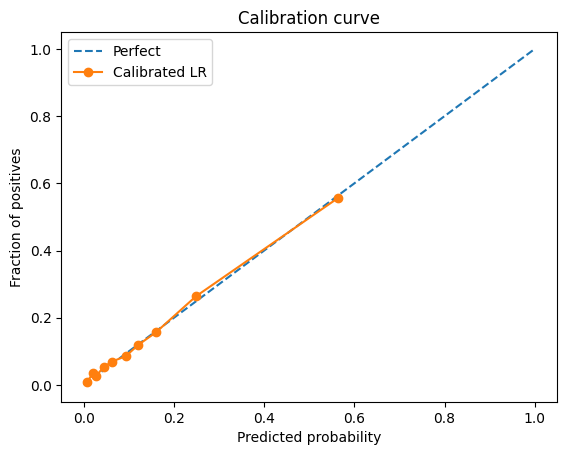

In [18]:
import matplotlib.pyplot as plt
f_true, f_pred = calibration_curve(y_te, p_cal, n_bins=10, strategy="quantile")

plt.figure()
plt.plot([0,1],[0,1], linestyle="--", label="Perfect")
plt.plot(f_pred, f_true, marker="o", label="Calibrated LR")
plt.xlabel("Predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration curve")
plt.legend()
plt.show()


In [19]:
import joblib
joblib.dump(cal, "healith_calibrated_lr.joblib")


['healith_calibrated_lr.joblib']

In [20]:
import numpy as np, pandas as pd
from sklearn.metrics import confusion_matrix

# p_cal = cal.predict_proba(X_te)[:,1]  # from your calibration step
def eval_thr(p, y, thr, c_fn=500, c_fp=10):
    yhat = (p >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, yhat).ravel()
    cost = fn*c_fn + fp*c_fp
    sens = tp / (tp + fn + 1e-9)     # recall
    spec = tn / (tn + fp + 1e-9)
    ppv  = tp / (tp + fp + 1e-9)     # precision
    return tp, fp, fn, tn, sens, spec, ppv, cost

ths = np.linspace(0.05, 0.60, 56)    # 0.05 → 0.60 by 0.01
rows = [(*eval_thr(p_cal, y_te, t), t) for t in ths]
thr_df = pd.DataFrame(rows, columns=["TP","FP","FN","TN","Recall","Specificity","Precision","Cost","Threshold"])
thr_df_sorted = thr_df.sort_values("Cost")
thr_df_sorted.head(10)


,TP,FP,FN,TN,Recall,Specificity,Precision,Cost,Threshold
0,500,1977,47,1476,0.914077,0.427454,0.201857,43270,0.05
1,491,1800,56,1653,0.897623,0.478714,0.214317,46000,0.06
2,475,1557,72,1896,0.868373,0.549088,0.233760,51570,0.07
3,461,1411,86,2042,0.842779,0.591370,0.246261,57110,0.08
4,459,1367,88,2086,0.839122,0.604112,0.251369,57670,0.09
5,454,1296,93,2157,0.829982,0.624674,0.259429,59460,0.10
6,444,1224,103,2229,0.811700,0.645526,0.266187,63740,0.11
7,400,884,147,2569,0.731261,0.743991,0.311526,82340,0.12
8,393,838,154,2615,0.718464,0.757312,0.319253,85380,0.13
9,378,743,169,2710,0.691042,0.784825,0.337199,91930,0.14


In [21]:
import sklearn, joblib
sklearn.__version__


'1.6.1'

In [22]:
import pandas as pd
from sklearn.metrics import confusion_matrix

def subgroup_metrics(p, y, thr, group):
    yhat = (p >= thr).astype(int)
    out = []
    for val in sorted(group.unique()):
        idx = (group == val)
        tn, fp, fn, tp = confusion_matrix(y[idx], yhat[idx]).ravel()
        recall = tp/(tp+fn+1e-9); precision = tp/(tp+fp+1e-9)
        out.append([val, recall, precision, fn, fp, tp, tn])
    return pd.DataFrame(out, columns=["Group","Recall","Precision","FN","FP","TP","TN"])

# using your calibrated test predictions p_cal, y_te, and X_te from earlier
tbl_region = subgroup_metrics(p_cal, y_te, 0.06, X_te["region"])
tbl_sex    = subgroup_metrics(p_cal, y_te, 0.06, X_te["sex"])
tbl_region, tbl_sex


(   Group    Recall  Precision  FN   FP   TP   TN
 0   East  0.869565   0.218341  15  358  100  374
 1  North  0.882812   0.206204  15  435  113  394
 2  South  0.914773   0.216981  15  581  161  477
 3   West  0.914062   0.215470  11  426  117  408,
   Group    Recall  Precision  FN   FP   TP   TN
 0     F  0.863636   0.207084  36  873  228  993
 1     M  0.929329   0.221008  20  927  263  660)